**optoSTING results - Figure 2 - Mathematical theory and numerical simulation of ReLU relation**

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from tqdm.notebook import tqdm
import numba as nb
from pde import ScalarField, CartesianGrid, PDEBase, FieldCollection

# One-dimensional steady state solution

\begin{align}
    & \mathbf{A} = \left(
        \begin{array}{cccccc}
            -2-\beta_1 & 1 & & & \cdots & 1 \\
            1 & -2-\beta_2 & 1 & & &  \\
             & 1 & -2-\beta_3 & 1 & & \\            
             & & \ddots & \ddots & \ddots &  \\
             &  & & 1 & -2-\beta_{n-1} & 1 \\
            1 & \cdots & &   & 1 & -2-\beta_n
        \end{array}
    \right), \;\; 
    \mathbf{c} = \left(
        \begin{array}{c}
            c_1 \\
            c_2 \\
            c_3 \\
            \vdots \\
            c_{n-1} \\
            c_n
        \end{array}
    \right)
\end{align}

  0%|          | 0/998 [00:00<?, ?it/s]

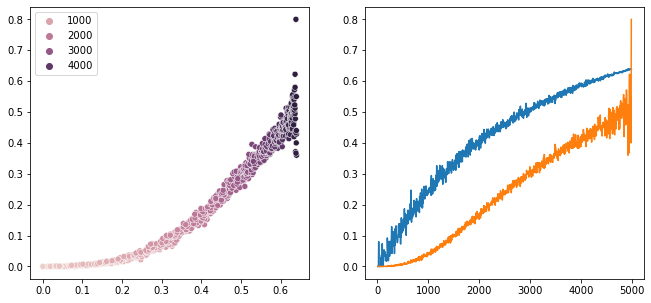

In [32]:
n = 5000
beta = 1e-1 
a = 1
# D = np.random.normal(1, 1, n) # np.array([1] * n) 
# D[D <= 0] = 0
D = np.ones(n)
D[np.random.choice(np.arange(n), int(n * 0.2), replace=False)] = 0.01
row = list(range(n)) + list(range(n-1)) + list(range(1,n)) + [0, n-1]
col = list(range(n)) + list(range(1,n)) + list(range(n-1)) + [n-1, 0]
data = (-2-beta/D).tolist() + [1] * 2 * n
A = csc_matrix((data, (row, col)), shape=(n, n))

sars = []
rars = []
m_values = np.arange(n // 1000, n // 1000 * 999, 5)
for m in tqdm(m_values):
    s = np.zeros(n)
    s[np.random.choice(np.arange(n), m, replace=False)] = 1
    sol = a * spsolve(A, s) # * np.random.normal(1, 0.2, (n, 1)) * 2
    sender = - sol[s==1]
    receiver = - sol[s==0]
    thresh = 2
    sar = (sender > thresh).sum() / len(sender)
    rar = (receiver > thresh).sum() / len(receiver)
    sars.append(sar)
    rars.append(rar)
_, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.scatterplot(x=sars, y=rars, hue=m_values, ax=ax[0])
ax[1].plot(m_values, sars)
ax[1].plot(m_values, rars)

# Two-dimensional steady-state solution

$$D\left(\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2}\right) + A - \gamma u = 0$$

$$\left(u_{i,j+1}+u_{i,j-1}+u_{i+1,j}+u_{i-1,j}-4u_{i,j}\right) + h^2\cdot\dfrac{A}{D} - h^2\cdot\dfrac{\gamma}{D} u_{i,j} = 0$$

## Varying mixing ratios

  0%|          | 0/98 [00:00<?, ?it/s]

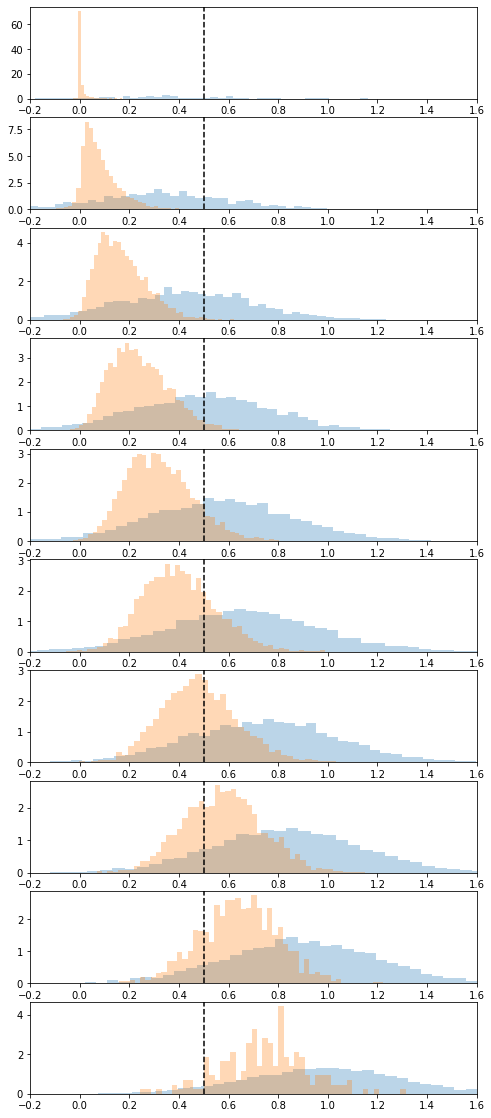

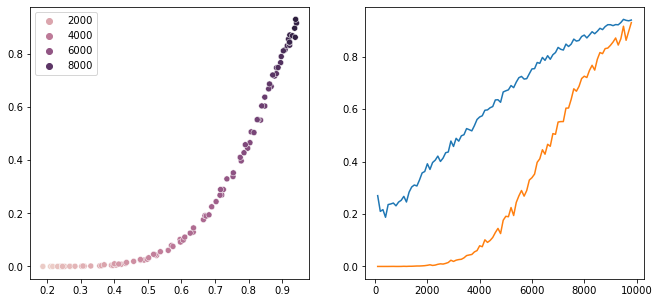

In [138]:
nGrid = 100 # Grid
a = 1
gamma = 1
D = np.random.normal(1, 0, nGrid ** 2)

sars = []
rars = []
row_ind = [i for i in range(nGrid**2-1) if not i % nGrid == nGrid-1] + [i for i in range(1, nGrid**2) if not i % nGrid == 0] + list(range(nGrid**2-nGrid)) + list(range(nGrid, nGrid**2))
col_ind = [i for i in range(1, nGrid**2) if not i % nGrid == 0] + [i for i in range(nGrid**2-1) if not i % nGrid == nGrid-1] + list(range(nGrid, nGrid**2)) + list(range(nGrid**2-nGrid))
data = [-1] * (nGrid-1) * nGrid * 2 + [-1] * (nGrid**2*2 - 2*nGrid)
A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(nGrid**2, nGrid**2))
A_arr_diag_compensation = np.array(np.sum(A_arr, axis=1)).flatten()
row_ind += list(range(nGrid**2))
col_ind += list(range(nGrid**2))
data += list(np.array([4] * nGrid**2) + gamma / D - A_arr_diag_compensation - 4)
A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(nGrid**2, nGrid**2))

m_values = [int(nGrid ** 2 * sr) for sr in np.arange(0.01, 0.99, 0.01)]

mplots = 10
_, axes = plt.subplots(mplots, 1, figsize=(8, 2 * mplots))
indices_for_plot = np.linspace(0, len(m_values)-1, 10).astype(int)
for i, m in enumerate(tqdm(m_values)):
    s = np.zeros(nGrid ** 2)
    s[np.random.choice(np.arange(nGrid ** 2), m, replace=False)] = 1
    b = np.random.normal(a, a, nGrid ** 2) * s / D
    result_ss = spsolve(A_arr, b)
    thresh = 0.5
    cs = result_ss[(s==1)]
    cr = result_ss[(s==0)]
    sar = (cs > thresh).sum() / ((s==1)).sum()
    rar = (cr > thresh).sum() / ((s==0)).sum()
    sars.append(sar)
    rars.append(rar)
    if i in indices_for_plot:
        ax = axes[np.where(indices_for_plot==i)[0][0]]
        ax.hist(cs, bins=50, density=True, alpha=0.3)
        ax.hist(cr, bins=50, density=True, alpha=0.3)
        ax.set_xlim([-0.2, 1.6])
        ax.axvline(x=thresh, color="k", linestyle="--")
    
_, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.scatterplot(x=sars, y=rars, hue=m_values, ax=ax[0])
ax[1].plot(m_values, sars)
ax[1].plot(m_values, rars)

## Varying light intensities

  0%|          | 0/75 [00:00<?, ?it/s]

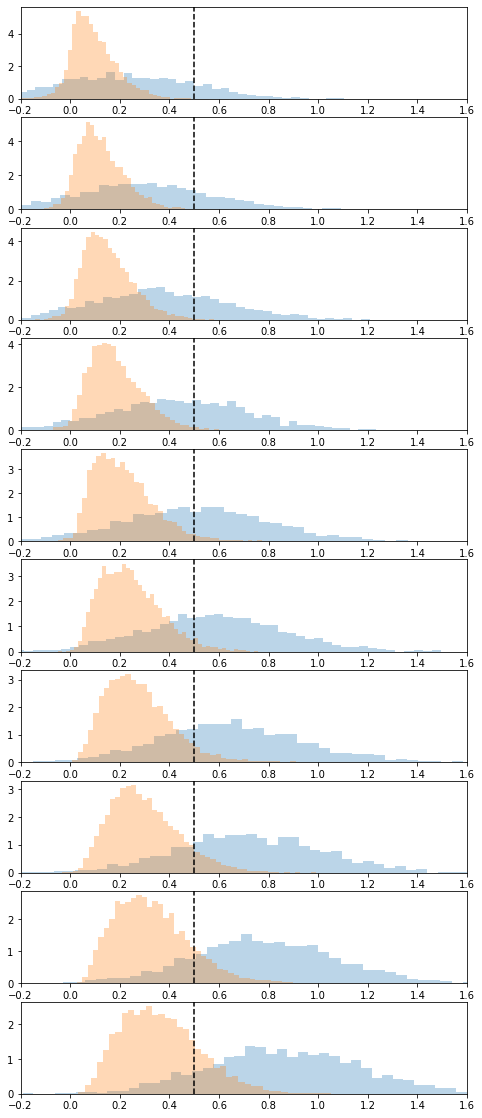

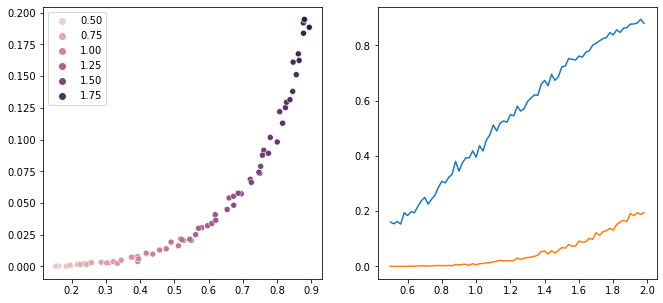

In [156]:
nGrid = 100 # Grid
gamma = 1
D = np.random.normal(1, 0, nGrid ** 2)

sars = []
rars = []
row_ind = [i for i in range(nGrid**2-1) if not i % nGrid == nGrid-1] + [i for i in range(1, nGrid**2) if not i % nGrid == 0] + list(range(nGrid**2-nGrid)) + list(range(nGrid, nGrid**2))
col_ind = [i for i in range(1, nGrid**2) if not i % nGrid == 0] + [i for i in range(nGrid**2-1) if not i % nGrid == nGrid-1] + list(range(nGrid, nGrid**2)) + list(range(nGrid**2-nGrid))
data = [-1] * (nGrid-1) * nGrid * 2 + [-1] * (nGrid**2*2 - 2*nGrid)
A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(nGrid**2, nGrid**2))
A_arr_diag_compensation = np.array(np.sum(A_arr, axis=1)).flatten()
row_ind += list(range(nGrid**2))
col_ind += list(range(nGrid**2))
data += list(np.array([4] * nGrid**2) + gamma / D - A_arr_diag_compensation - 4)
A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(nGrid**2, nGrid**2))


a_values = np.arange(0.5, 2, 0.02)
mplots = 10
_, axes = plt.subplots(mplots, 1, figsize=(8, 2 * mplots))
indices_for_plot = np.linspace(0, len(a_values)-1, 10).astype(int)
for i, a in enumerate(tqdm(a_values)):
    s = np.zeros(nGrid ** 2)
    s[np.random.choice(np.arange(nGrid ** 2), nGrid ** 2 // 4, replace=False)] = 1
    b = np.random.normal(a, 1, nGrid ** 2) * s / D
    result_ss = spsolve(A_arr, b)
    thresh = 0.5
    cs = result_ss[(s==1)]
    cr = result_ss[(s==0)]
    sar = (cs > thresh).sum() / ((s==1)).sum()
    rar = (cr > thresh).sum() / ((s==0)).sum()
    sars.append(sar)
    rars.append(rar)
    if i in indices_for_plot:
        ax = axes[np.where(indices_for_plot==i)[0][0]]
        ax.hist(cs, bins=50, density=True, alpha=0.3)
        ax.hist(cr, bins=50, density=True, alpha=0.3)
        ax.set_xlim([-0.2, 1.6])
        ax.axvline(x=thresh, color="k", linestyle="--")
    
_, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.scatterplot(x=sars, y=rars, hue=a_values, ax=ax[0])
ax[1].plot(a_values, sars)
ax[1].plot(a_values, rars)

  0%|          | 0/75 [00:00<?, ?it/s]

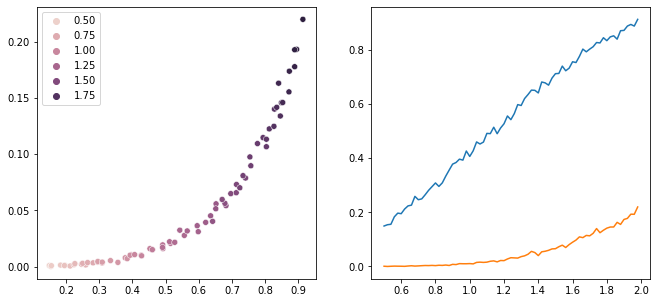

In [154]:
nGrid = 100 # Grid
# D = np.ones(nGrid ** 2)
# D[np.random.choice(np.arange(nGrid ** 2), int(nGrid ** 2 * 0.1), replace=False)] = 0.01
D = np.random.normal(1, 0.2, nGrid ** 2)
gamma = 1

sars = []
rars = []

m = int(nGrid ** 2 * 0.25)
row_ind = [i for i in range(nGrid**2-1) if not i % nGrid == nGrid-1] + [i for i in range(1, nGrid**2) if not i % nGrid == 0] + list(range(nGrid**2-nGrid)) + list(range(nGrid, nGrid**2))
col_ind = [i for i in range(1, nGrid**2) if not i % nGrid == 0] + [i for i in range(nGrid**2-1) if not i % nGrid == nGrid-1] + list(range(nGrid, nGrid**2)) + list(range(nGrid**2-nGrid))
data = [-1] * (nGrid-1) * nGrid * 2 + [-1] * (nGrid**2*2 - 2*nGrid)
A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(nGrid**2, nGrid**2))
A_arr_diag_compensation = np.array(np.sum(A_arr, axis=1)).flatten()
row_ind += list(range(nGrid**2))
col_ind += list(range(nGrid**2))
data += list(np.array([4] * nGrid**2) + gamma / D - A_arr_diag_compensation - 4)
A_arr = csc_matrix((data, (row_ind, col_ind)), shape=(nGrid**2, nGrid**2))

a_values = np.arange(0.5, 2, 0.02)
for a in tqdm(a_values):
    s = np.zeros(nGrid ** 2)
    s[np.random.choice(np.arange(nGrid ** 2), m, replace=False)] = 1
    b = np.random.normal(a, 1, nGrid ** 2) * s / D
    result_ss = spsolve(A_arr, b)
    thresh = 0.5
    cs = result_ss[s==1]
    cr = result_ss[s==0]
    sar = (cs > thresh).sum() / (s==1).sum()
    rar = (cr > thresh).sum() / (s==0).sum()
    sars.append(sar)
    rars.append(rar)
_, ax = plt.subplots(1, 2, figsize=(11, 5))
sns.scatterplot(x=sars, y=rars, hue=a_values, ax=ax[0])
ax[1].plot(a_values, sars)
ax[1].plot(a_values, rars)

# Two-dimensional dynamic simulations

## Equations

In [3]:
nGrid = 50

class SRSystem_2D(PDEBase):
    def __init__(
        self,
        initial_activ_cells,
        D=1,
        D0=1e-2,
        disconnect=0.4,
        A=1,
        gamma=0.1,
        beta=0.01,
        bc=[{"derivative": 0}] * 2,
        duration=3600,
        noise=0,
    ):
        self.initial_activ_cells = initial_activ_cells
        self.D = D
        self.D0 = D
        self.disconnect = disconnect
        self.A = A
        self.gamma = gamma
        self.bc = bc
        self.duration = duration
        self.noise = noise
        self.check_implementation = False
        self.beta = beta

    def get_initial_state(self, grid):
        """Initial condition"""
        return FieldCollection([ScalarField(grid, 0, label=lb) for lb in ["CDN", "STING"]])

    def evolution_rate(self, state, t=0):
        u, v = state
        D_arr = self.D * np.ones_like(u.data).flatten()
        nCells = (u.data.shape[0])**2
        D_arr[np.random.choice(np.arange(nCells), int(nCells * self.disconnect), replace=False)] = self.D0
        D_arr = D_arr.reshape(u.data.shape)
        u_t = (
            D_arr * u.laplace(bc=self.bc)
            + self.A * self.initial_activ_cells # * (t < self.duration)
            - self.gamma * u.data
        )
        v_t = self.gamma * u - v
        return FieldCollection([u_t, v_t])

    def _make_pde_rhs_numba(self, state):
        D = self.D
        D0 = self.D0
        disconnect = self.disconnect
        A = self.A
        beta = self.beta
        gamma = self.gamma
        duration = self.duration
        x = state.grid.cell_coords[:, :, 0]
        laplace = state.grid.get_operator("laplace", bc=self.bc)
        initial_activ_cells = self.initial_activ_cells

        @nb.jit
        def pde_rhs(state_data, t):
            u, v = state_data[0], state_data[1]
            D_arr = D * np.ones_like(u).flatten()
            nCells = (u.shape[0]) ** 2
            D_arr[np.random.choice(np.arange(nCells), int(nCells * disconnect), replace=False)] = D0
            D_arr = D_arr.reshape(u.shape)
            rate = np.empty_like(state_data)
            rate[0] = (
                D_arr * laplace(u)
                + A * initial_activ_cells # * np.float64(t < duration)
                - gamma * u
            )
            rate[1] = gamma * u - v
            return rate

        return pde_rhs
    
def initialize_cell_map_2D(sr, size=(nGrid, nGrid)):
    cell_map = np.zeros(size).flatten()
    n_sender = np.floor(len(cell_map) * sr).astype(int)
    cell_map[np.random.choice(np.arange(len(cell_map)), n_sender, replace=False)] = 1
    cell_map = cell_map.reshape(size)
    return cell_map

In [6]:
tspan = 600
dt = 1e-1
thresh = 3
cs_group = []
cr_group = []
for sr in tqdm(np.arange(0.01, 0.99, 0.02)):
    grid = CartesianGrid([[0, nGrid]] * 2, nGrid, periodic=False)
    s = initialize_cell_map_2D(sr=sr)
    eq = SRSystem_2D(initial_activ_cells=s)
    state = eq.get_initial_state(grid)
    result = eq.solve(state, t_range=tspan, dt=dt, tracker=['consistency'])[0].data
    cs = result[s == 1]
    cr = result[s == 0]
    cs_group.append(cs)
    cr_group.append(cr)

  0%|          | 0/20 [00:00<?, ?it/s]

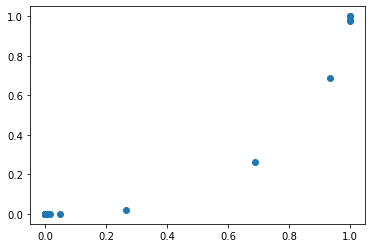

In [8]:
thresh = 7
sars = np.array([(cs > thresh).sum() for cs in cs_group]) / np.arange(0.01, 0.99, 0.05) / nGrid**2
rars = np.array([(cr > thresh).sum() for cr in cr_group]) / (1 - np.arange(0.01, 0.99, 0.05)) / nGrid ** 2
plt.scatter(sars, rars)

In [284]:
cr_group

[array([1.82097872e-06, 1.76317918e-05, 2.63175364e-05, ...,
        1.33551618e-06, 8.45499376e-07, 2.89367632e-06]),
 array([1.37158506e-04, 3.34998111e-04, 2.99059198e-04, ...,
        1.00917367e-01, 1.05460436e+00, 7.69593303e-01]),
 array([5.60843581e-01, 3.68406442e+00, 2.91986455e+00, ...,
        2.12285231e-03, 2.20239902e-03, 2.26799284e-04]),
 array([0.00519414, 0.0022156 , 0.01369627, ..., 0.13994602, 2.09564628,
        0.71674606]),
 array([0.01753039, 0.02272265, 0.01784275, ..., 0.00366011, 0.00085866,
        0.00085428]),
 array([0.2970225 , 0.55135799, 0.82681237, ..., 0.58108902, 0.14452361,
        0.66537426]),
 array([0.03752213, 0.02916823, 0.30709959, ..., 0.09410497, 0.2829344 ,
        0.18826144]),
 array([0.08986421, 0.04877696, 0.28204473, ..., 5.00532232, 3.03343501,
        1.68574816]),
 array([0.10861185, 0.0736921 , 0.53439891, ..., 2.46122109, 0.28773778,
        0.65554195]),
 array([1.5400488 , 0.7022979 , 0.15880124, ..., 1.23839239, 0.8346013 ,
